In [4]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape
import matplotlib.patches as patches

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json



def load_image(image_path, resize=True):
    # Load the image without resizing
    image = Image.open(image_path)
    if resize:
        image = image.resize((256, 256))  # Resize for model consistency
    return np.array(image) / 255.0  # Normalize and return image data

def load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center = float(box['x']) + 7.5  # 15/2 to get center
                y_center = float(box['y']) + 7.5  # 15/2 to get center
                x_min = (x_center - 7.5) / img_width
                y_min = (y_center - 7.5) / img_height
                x_max = (x_center + 7.5) / img_width
                y_max = (y_center + 7.5) / img_height
                labels.append([x_min, y_min, x_max, y_max])

        # Pad labels if less than num_boxes
        while len(labels) < num_boxes:
            labels.append([0, 0, 0, 0])  # Padding with dummy coordinates
    return labels

def create_model(num_boxes=20, num_coords=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model

def compile_model(model, learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mse', 'accuracy'])
    return model
    

def data_generator(image_paths, json_paths, batch_size, num_boxes=20):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                image = load_image(image_paths[i])
                labels = load_labels_for_detection(json_paths[i], 256, 256, num_boxes)
                batch_images.append(image)
                batch_labels.append(labels)
            yield np.array(batch_images), np.array(batch_labels)
def train_model(model, train_gen, steps_per_epoch, epochs):
    history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs)
    return history

def load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center = float(box['x']) + 7.5  # 15/2 to get center
                y_center = float(box['y']) + 7.5  # 15/2 to get center
                x_min = (x_center - 7.5) / img_width
                y_min = (y_center - 7.5) / img_height
                x_max = (x_center + 7.5) / img_width
                y_max = (y_center + 7.5) / img_height
                labels.append([x_min, y_min, x_max, y_max])
        while len(labels) < num_boxes:
            labels.append([0, 0, 0, 0])  # Padding with dummy coordinates
    return labels

def show_predictions(model, image_paths, json_paths, num_samples=5, num_boxes=20):
    fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples * 10))  # 2 columns for side by side display
    for i in range(num_samples):
        original_image = load_image(image_paths[i], resize=False)
        model_input_image = load_image(image_paths[i], resize=True)  # Resized for the model
        img_height, img_width, _ = original_image.shape  # Get the original image dimensions
        true_labels = load_labels_for_detection(json_paths[i], img_width, img_height)
        predicted_labels = model.predict(model_input_image[np.newaxis, ...])[0]

        # Display original image with true annotations
        axs[i, 0].imshow(original_image)
        axs[i, 0].set_title(f'Image {i+1} - Ground Truth')
        if os.path.exists(json_paths[i]):
            with open(json_paths[i], 'r') as file:
                data = json.load(file)
            for box in data['boxes']:
                if box['label'] == 'ball':
                    x_center = float(box['x'])
                    y_center = float(box['y'])
                    width = 15  # Assuming width of 15 for the ball
                    height = 15  # Assuming height of 15 for the ball
                    x = x_center - width / 2
                    y = y_center - height / 2
                    rect_true = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')
                    axs[i, 0].add_patch(rect_true)

        # Display original image with predicted annotations
        axs[i, 1].imshow(original_image)
        axs[i, 1].set_title(f'Image {i+1} - Predictions')
        for pred in predicted_labels:
            center_x = pred[0] * 256
            center_y = pred[1] * 256
            width = (pred[2] - pred[0]) * 256
            height = (pred[3] - pred[1]) * 256
            top_left_x = center_x - width / 2
            top_left_y = center_y - height / 2
            rect_pred = patches.Rectangle((top_left_x, top_left_y),
                                          width,
                                          height, linewidth=2, edgecolor='r', facecolor='none')
            axs[i, 1].add_patch(rect_pred)

            # Print predicted coordinates for debugging
            print(f"Image {i+1} - Prediction {pred}: Center ({center_x:.2f}, {center_y:.2f}), Width: {width:.2f}, Height: {height:.2f}")
    plt.show()

# Example usage
image_paths = [f'../images/image_{i}.png' for i in range(1, 100)]
json_paths = [f'../json_labeling/label_{i}.json' for i in range(1, 100)]

# Create and compile model
model = create_model()
compile_model(model, learning_rate=0.0001)

# Create data generator and train model
batch_size = 32
train_gen = data_generator(image_paths, json_paths, batch_size)
history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // batch_size, epochs=10)

# Display predictions
show_predictions(model, image_paths, json_paths)

##
# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['mse'], label='MSE')
    plt.title('Model Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/MSE')
    plt.legend()
    plt.show()

plot_history(history)

# Display predictions
show_predictions(model, image_paths, json_paths, num_samples=5, num_boxes=20)
##



def load_image(image_path, resize=True):
    # Load the image without resizing
    image = Image.open(image_path)
    if resize:
        image = image.resize((256, 256))  # Resize for model consistency
    return np.array(image) / 255.0  # Normalize and return image data

def load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center = float(box['x']) + 7.5  # 15/2 to get center
                y_center = float(box['y']) + 7.5  # 15/2 to get center
                x_min = (x_center - 7.5) / img_width
                y_min = (y_center - 7.5) / img_height
                x_max = (x_center + 7.5) / img_width
                y_max = (y_center + 7.5) / img_height
                labels.append([x_min, y_min, x_max, y_max])
        # Pad labels if less than num_boxes
        while len(labels) < num_boxes:
            labels.append([0, 0, 0, 0])  # Padding with dummy coordinates
    return labels

# Adding Dropout
def create_model(num_boxes=20, num_coords=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),  # Dropout added here
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # and here
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model

def compile_model(model):
    optimizer = Adam(learning_rate=0.1)
    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error for bounding box regression
                  metrics=['mse', 'accuracy']) 

# Initialize the ImageDataGenerator with some augmentation parameters
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
    
def data_generator(image_paths, json_paths, batch_size, num_boxes=20):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                # Load the image and resize
                image = load_image(image_paths[i], resize=True)
                labels = load_labels_for_detection(json_paths[i], 256, 256, num_boxes)
                
                # Augment the image - since ImageDataGenerator works with batches,
                # we need to expand dimensions to simulate a batch
                image = np.expand_dims(image, 0)  # Expand dims to make it (1, 256, 256, 3)
                image = data_gen.flow(image, batch_size=1).next()[0]  # Apply augmentation
                
                batch_images.append(image)
                batch_labels.append(labels)
            yield np.array(batch_images), np.array(batch_labels)

# Adding Dropout
def create_model(num_boxes=20, num_coords=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),  # Dropout added here
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # and here
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model

def train_model(model, train_gen, steps_per_epoch, epochs):
    history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs)
    return history

def load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center = float(box['x']) + 7.5  # 15/2 to get center
                y_center = float(box['y']) + 7.5  # 15/2 to get center
                x_min = (x_center - 7.5) / img_width
                y_min = (y_center - 7.5) / img_height
                x_max = (x_center + 7.5) / img_width
                y_max = (y_center + 7.5) / img_height
                labels.append([x_min, y_min, x_max, y_max])
        while len(labels) < num_boxes:
            labels.append([0, 0, 0, 0])  # Padding with dummy coordinates
    return labels

def show_predictions(model, image_paths, json_paths, num_samples=5, num_boxes=20):
    fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples * 10))  # 2 columns for side by side display
    for i in range(num_samples):
        original_image = load_image(image_paths[i], resize=False)
        model_input_image = load_image(image_paths[i], resize=True)  # Resized for the model
        img_height, img_width, _ = original_image.shape  # Get the original image dimensions

        true_labels = load_labels_for_detection(json_paths[i], img_width, img_height)
        predicted_labels = model.predict(model_input_image[np.newaxis, ...])[0]

        # Display original image with true annotations
        axs[i, 0].imshow(original_image)
        axs[i, 0].set_title(f'Image {i+1} - Ground Truth')
        if os.path.exists(json_paths[i]):
            with open(json_paths[i], 'r') as file:
                data = json.load(file)
            for box in data['boxes']:
                if box['label'] == 'ball':
                    x_center = float(box['x'])
                    y_center = float(box['y'])
                    width = 15  # Assuming width of 15 for the ball
                    height = 15  # Assuming height of 15 for the ball
                    x = x_center - width / 2
                    y = y_center - height / 2
                    rect_true = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')
                    axs[i, 0].add_patch(rect_true)

        # Display original image with predicted annotations
        axs[i, 1].imshow(original_image)
        axs[i, 1].set_title(f'Image {i+1} - Predictions')
        for pred in predicted_labels:
            center_x = pred[0] * 256
            center_y = pred[1] * 256
            width = (pred[2] - pred[0]) * 256
            height = (pred[3] - pred[1]) * 256
            top_left_x = center_x - width / 2
            top_left_y = center_y - height / 2
            rect_pred = patches.Rectangle((top_left_x, top_left_y),
                                          width,
                                          height, linewidth=2, edgecolor='r', facecolor='none')
            axs[i, 1].add_patch(rect_pred)

            # Print predicted coordinates for debugging
            print(f"Image {i+1} - Prediction {pred}: Center ({center_x:.2f}, {center_y:.2f}), Width: {width:.2f}, Height: {height:.2f}")
    plt.show()

# Example usage
image_paths = [f'../images/image_{i}.png' for i in range(1, 100)]
json_paths = [f'../json_labeling/label_{i}.json' for i in range(1, 100)]

# Create and compile model
model = create_model()
compile_model(model, learning_rate=0.2)

# Create data generator and train model
batch_size = 32

#data_generator(image_paths, json_paths, batch_size)
#train_gen = data_generator(image_paths, json_paths, batch_size)

#history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // batch_size, epochs=10)

# Proceed with training as before
train_gen = data_generator(image_paths, json_paths, batch_size)
history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // batch_size, epochs=10)


# Display predictions
#show_predictions(model, image_paths, json_paths)
'''

'import tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense\nfrom tensorflow.keras.layers import Reshape\nimport matplotlib.patches as patches\n\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.layers import Dropout\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\nimport os\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nimport numpy as np\nimport json\n\n\n\ndef load_image(image_path, resize=True):\n    # Load the image without resizing\n    image = Image.open(image_path)\n    if resize:\n        image = image.resize((256, 256))  # Resize for model consistency\n    return np.array(image) / 255.0  # Normalize and return image data\n\ndef load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):\n    labels = []\n    if json_path:\n        with open(json_path, \'r\') as file:\n            data = json.load(file)\n        for box in da

In [5]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

def load_image(image_path, resize=True):
    """Load and normalize an image."""
    image = Image.open(image_path)
    if resize:
        image = image.resize((256, 256))
    return np.array(image) / 255.0

def load_labels(json_path, img_width, img_height, num_boxes=20):
    """Load labels for detection from JSON file."""
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
            for box in data['boxes']:
                if box['label'] == 'ball':
                    x_center, y_center = float(box['x']) + 7.5, float(box['y']) + 7.5
                    labels.append([
                        (x_center - 7.5) / img_width,
                        (y_center - 7.5) / img_height,
                        (x_center + 7.5) / img_width,
                        (y_center + 7.5) / img_height,
                    ])
        labels += [[0, 0, 0, 0]] * (num_boxes - len(labels))
    return labels

def create_model(num_boxes=20, num_coords=4):
    """Build a CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2), Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'), Dropout(0.5),
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model

def compile_model(model, learning_rate=0.0001):
    """Compile the CNN model."""
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse', metrics=['mse', 'accuracy'])

def data_generator(image_paths, json_paths, batch_size, num_boxes=20):
    """Generate data batches."""
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = [load_image(image_paths[i]) for i in range(start, end)]
            batch_labels = [load_labels(json_paths[i], 256, 256, num_boxes) for i in range(start, end)]
            yield np.array(batch_images), np.array(batch_labels)

def train_model(model, train_gen, steps_per_epoch, epochs=10):
    """Train the model."""
    return model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs)

def show_predictions(model, image_paths, json_paths, num_samples=5):
    """Visualize predictions from the model alongside the ground truth."""
    fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples * 10))
    for i in range(num_samples):
        original_img = load_image(image_paths[i], resize=False)
        model_input_img = load_image(image_paths[i], resize=True)
        original_width, original_height = original_img.shape[1], original_img.shape[0]

        # Load labels and predictions
        labels = load_labels(json_paths[i], original_width, original_height)
        predictions = model.predict(np.expand_dims(model_input_img, 0))[0]

        for ax, title, boxes in zip(axs[i], ['Ground Truth', 'Predictions'], [labels, predictions]):
            ax.imshow(original_img)
            ax.set_title(f'Image {i+1} - {title}')
            for x_min, y_min, x_max, y_max in boxes:
                rect = patches.Rectangle(
                    (x_min * original_width, y_min * original_height),
                    (x_max - x_min) * original_width,
                    (y_max - y_min) * original_height,
                    linewidth=2, edgecolor='r' if title == 'Predictions' else 'g', facecolor='none')
                ax.add_patch(rect)
    plt.show()

# Setupx
image_paths = [f'../images/image_{i}.png' for i in range(1, 100)]
json_paths = [f'../json_labeling/label_{i}.json' for i in range(1, 100)]
model = create_model()
compile_model(model)
train_gen = data_generator(image_paths, json_paths, batch_size=32)
history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // 32)
show_predictions(model, image_paths, json_paths)
'''


'import tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as patches\nfrom PIL import Image\nimport numpy as np\nimport json\n\ndef load_image(image_path, resize=True):\n    """Load and normalize an image."""\n    image = Image.open(image_path)\n    if resize:\n        image = image.resize((256, 256))\n    return np.array(image) / 255.0\n\ndef load_labels(json_path, img_width, img_height, num_boxes=20):\n    """Load labels for detection from JSON file."""\n    labels = []\n    if json_path:\n        with open(json_path, \'r\') as file:\n            data = json.load(file)\n            for box in data[\'boxes\']:\n                if box[\'label\'] == \'ball\':\n                    x_center, y_center = float(box

## Participants
Uffe       - s224275  
Aleksander - s185289

1. Problem Definition  
The primary goal of this project is to develop a convolutional neural network (CNN) that can detect  
and localize specific objects (in this case, "balls") within images. The model should output bounding  
boxes indicating the location of each detected object. This includes recognizing the presence, size,  
and position of balls.

2. Data Extraction and Data Processing  
Data Extraction:  
The data for this project consists of images and corresponding JSON files that provide annotations  
for these images. Each JSON file contains bounding box coordinates for balls within the images.  

Data Processing:  
Image Loading: Images are loaded using the load_image function, which also resizes them to  
256x256 pixels to ensure consistency in input size for the model. This resizing is crucial as it  
normalizes the input dimensions for the neural network.  

Label Loading:  
The load_labels function extracts bounding box coordinates from the JSON  
files. These coordinates are normalized relative to the image dimensions to ensure they are  
scale-invariant and correspond to the resized images.

3. Modeling  
Model Architecture:  
The model is a Sequential CNN composed of the following layers:  

Convolutional Layers:  
To extract features from the images. Each convolutional layer is followed  
by batch normalization and max pooling to reduce spatial dimensions and prevent overfitting.

Dropout Layers:  
Included after max pooling to further prevent overfitting by randomly turning  
off some neurons during training.

Dense Layers:  
A fully connected layer to interpret the features extracted by the convolutional  
layers, followed by a reshape layer that formats the output to match the expected structure of  
bounding box coordinates.

Compilation:  
The model is compiled with the Adam optimizer and Mean Squared Error (MSE) loss function,  
which is appropriate for the regression nature of predicting bounding box coordinates.

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.2855 - loss: 0.5839 - mse: 0.5839
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.1736 - loss: 0.3738 - mse: 0.3738 
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1288 - loss: 0.3040 - mse: 0.3040  
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1403 - loss: 0.3125 - mse: 0.3125
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.1114 - loss: 0.3309 - mse: 0.3309
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.1124 - loss: 0.3291 - mse: 0.3291 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1027 - loss: 0.2791 - mse: 0.2791  
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1224 - loss: 0.3046 - mse: 0.3046
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.1011 - loss: 0.3083 - mse: 0.3083
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.1001 - loss: 0.3270 - mse: 0.3270 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1

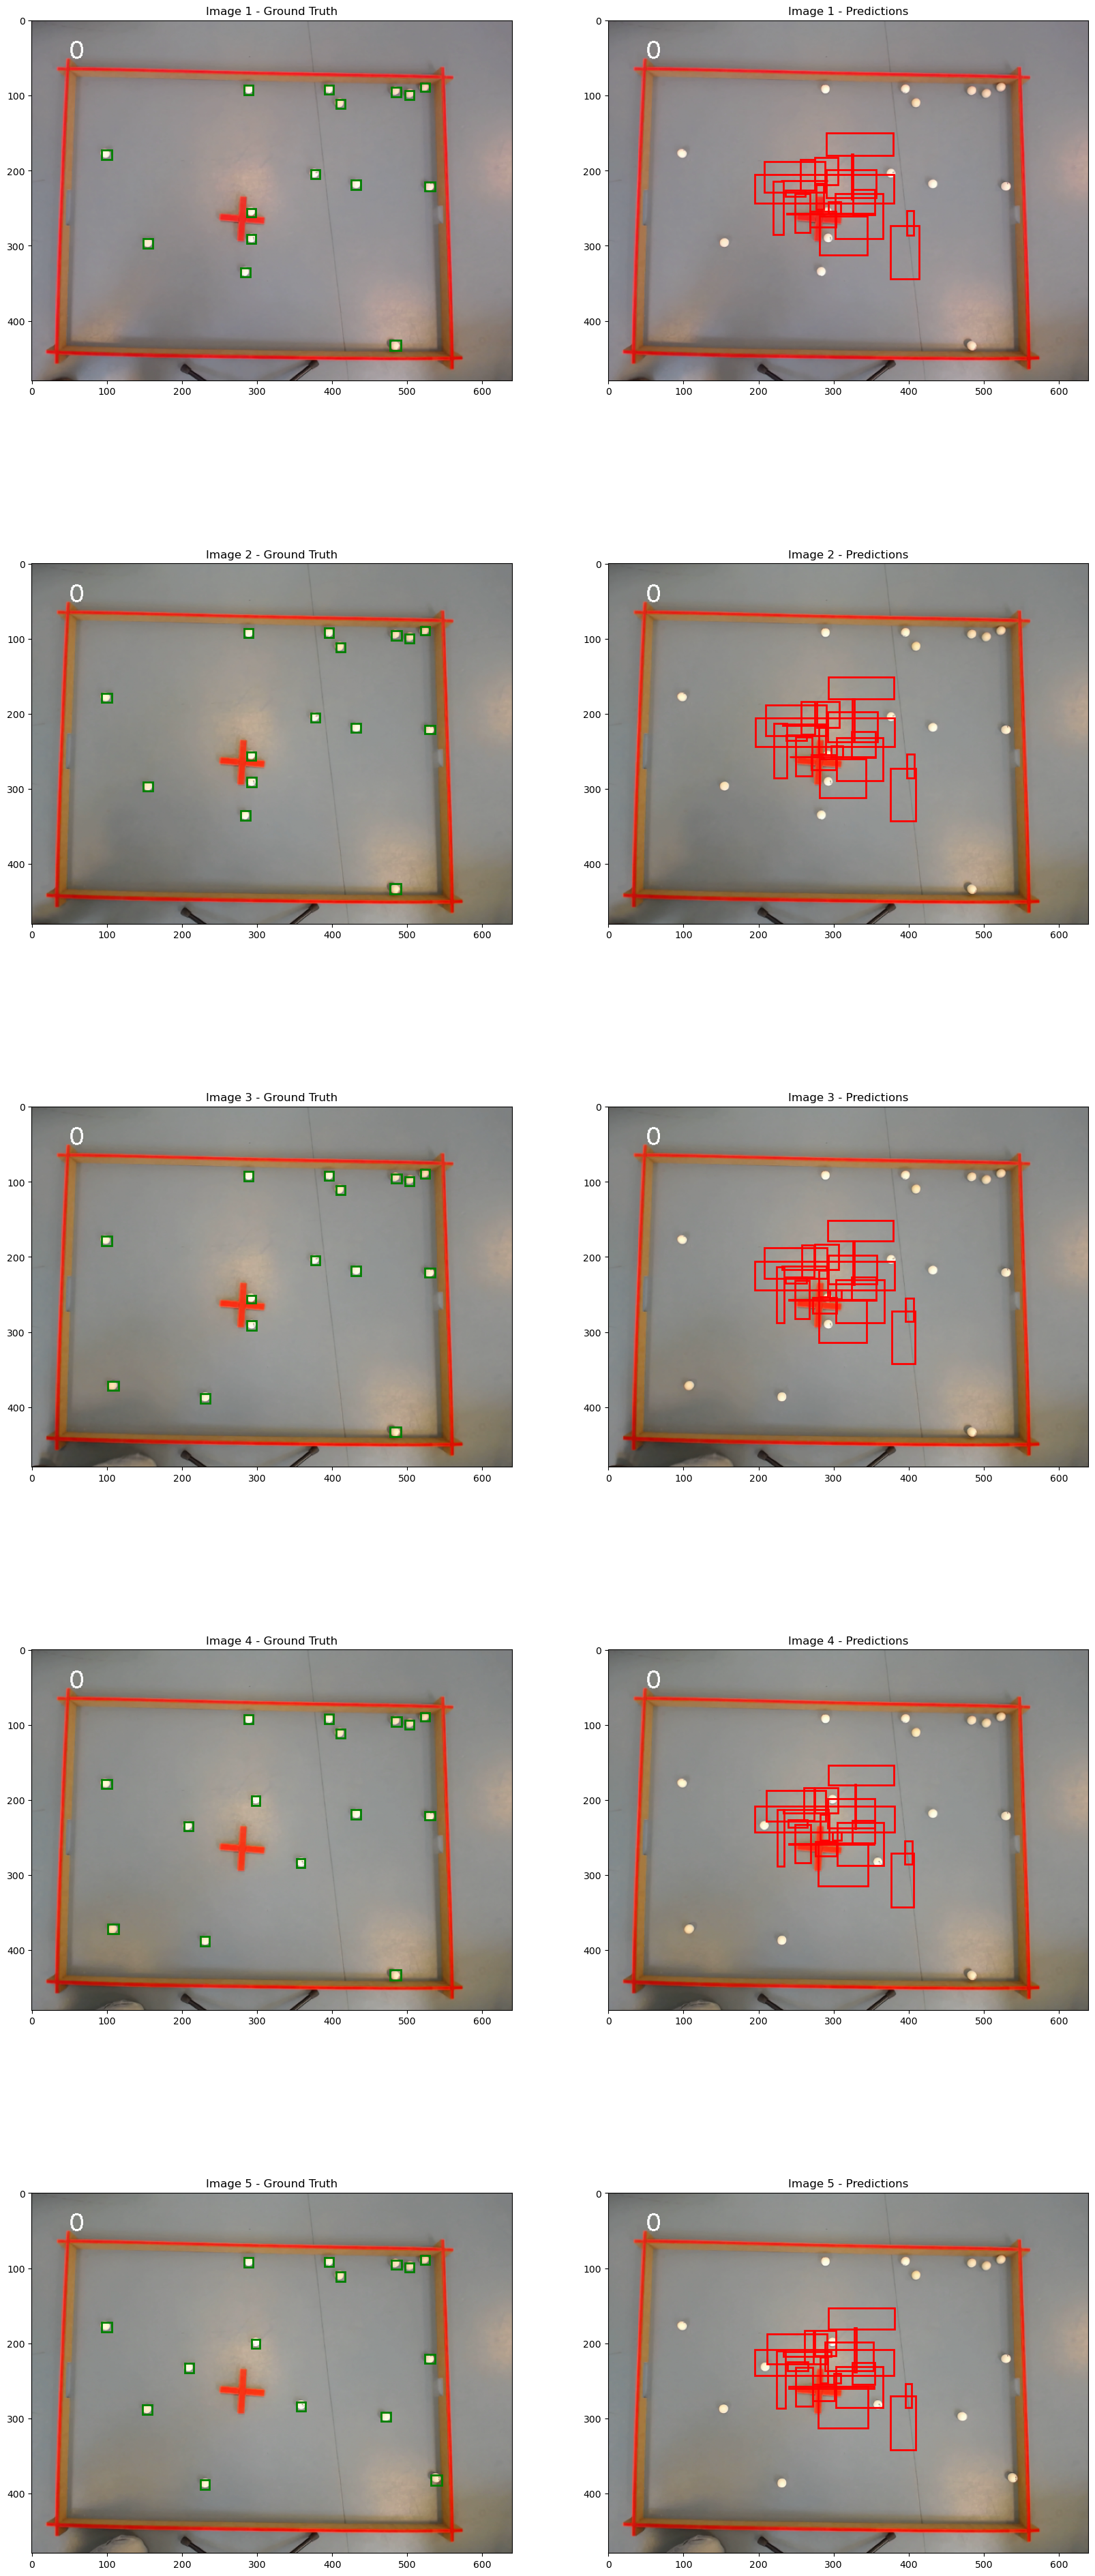

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json
from tensorflow.keras.layers import BatchNormalization


def load_image(image_path, resize=True):
    """Load and normalize an image."""
    with Image.open(image_path) as img:
        if resize:
            img = img.resize((256, 256))
        return np.array(img) / 255.0

def load_labels(json_path, img_width, img_height, num_boxes=20):
    """Load labels for detection from JSON file."""
    labels = []
    with open(json_path, 'r') as file:
        data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center, y_center = float(box['x']), float(box['y'])
                width, height = float(box['width']), float(box['height'])
                # Calculate top-left and bottom-right coordinates
                x_min = (x_center - width / 2) / img_width
                y_min = (y_center - height / 2) / img_height
                x_max = (x_center + width / 2) / img_width
                y_max = (y_center + height / 2) / img_height
                labels.append([x_min, y_min, x_max, y_max])
    labels += [[0, 0, 0, 0]] * (num_boxes - len(labels))
    return labels


def create_model(num_boxes=20, num_coords=4):
    """Updated model with Batch Normalization."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2), 
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'), 
        Dropout(0.5),
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model


def compile_model(model, learning_rate=0.0001):
    """Compile the CNN model with specified learning rate."""
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse', metrics=['mse', 'accuracy'])

def data_generator(image_paths, json_paths, batch_size, num_boxes=20):
    """Yield batches of images and labels for training."""
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = [load_image(path) for path in image_paths[start:end]]
            batch_labels = [load_labels(json_paths[i], 256, 256, num_boxes) for i in range(start, end)]
            yield np.array(batch_images), np.array(batch_labels)

def train_model(model, train_gen, steps_per_epoch, epochs=10):
    """Train the model and return the history."""
    return model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs)

def show_predictions(model, image_paths, json_paths, num_samples=5):
    """Visualize predictions from the model alongside the ground truth."""
    fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples * 10))
    for i in range(num_samples):
        original_img = load_image(image_paths[i], resize=False)
        model_input_img = load_image(image_paths[i], resize=True)
        original_width, original_height = original_img.shape[1], original_img.shape[0]

        # Load labels and predictions
        labels = load_labels(json_paths[i], original_width, original_height)
        predictions = model.predict(np.expand_dims(model_input_img, 0))[0]

        for ax, title, boxes in zip(axs[i], ['Ground Truth', 'Predictions'], [labels, predictions]):
            ax.imshow(original_img)
            ax.set_title(f'Image {i+1} - {title}')
            for x_min, y_min, x_max, y_max in boxes:
                rect = patches.Rectangle(
                    (x_min * original_width, y_min * original_height),
                    (x_max - x_min) * original_width,
                    (y_max - y_min) * original_height,
                    linewidth=2, edgecolor='r' if title == 'Predictions' else 'g', facecolor='none')
                ax.add_patch(rect)
    plt.show()



# Main execution setup
if __name__ == "__main__":
    image_paths = [f'../images/image_{i}.png' for i in range(1, 100)]
    json_paths = [f'../json_labeling/label_{i}.json' for i in range(1, 100)]
    model = create_model()
    compile_model(model)
    train_gen = data_generator(image_paths, json_paths, batch_size=32)
    history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // 32)
    show_predictions(model, image_paths, json_paths)


4. Performance Evaluation  
Training:  
The model is trained using a custom data generator, which feeds batches of images  
and their corresponding labels to the model. This approach is memory efficient and necessary  
for handling large datasets.  
Metrics: While the code uses MSE for training, additional metrics such as Intersection over  
Union (IoU) or accuracy of detected boxes (how many predicted boxes are valid) could be  
calculated post-training to provide more insight into model performance.

5. Results Explanation  
Visualization of Predictions: The show_predictions function visualizes the model's predictions  
by overlaying the predicted bounding boxes on the original images alongside the actual annotations.  
This visual comparison helps in qualitatively assessing the model's performance.  
Interpreting Results: From the visualization, one can assess how well the model has learned to  
identify and localize objects within images. The effectiveness of the model can be seen in how  
closely the predicted boxes match the ground truth annotations.  
  
Which in this case is not as good as we had hoped, This could be the result of a list of problems, such as:
* An inability to understand the Json data both in terms of the amount of balls, and the labels to the balss
* Not enough Complexity in the model, as the model might not be deep enough
* the learning rate or epoch amount could make the model not train enough for it to find a pattern.
* Data processing, the images in the convolution and pooling could be of the wrong appropriate size.
* Underfitting, the model might not have the appropriate amount of data to train the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


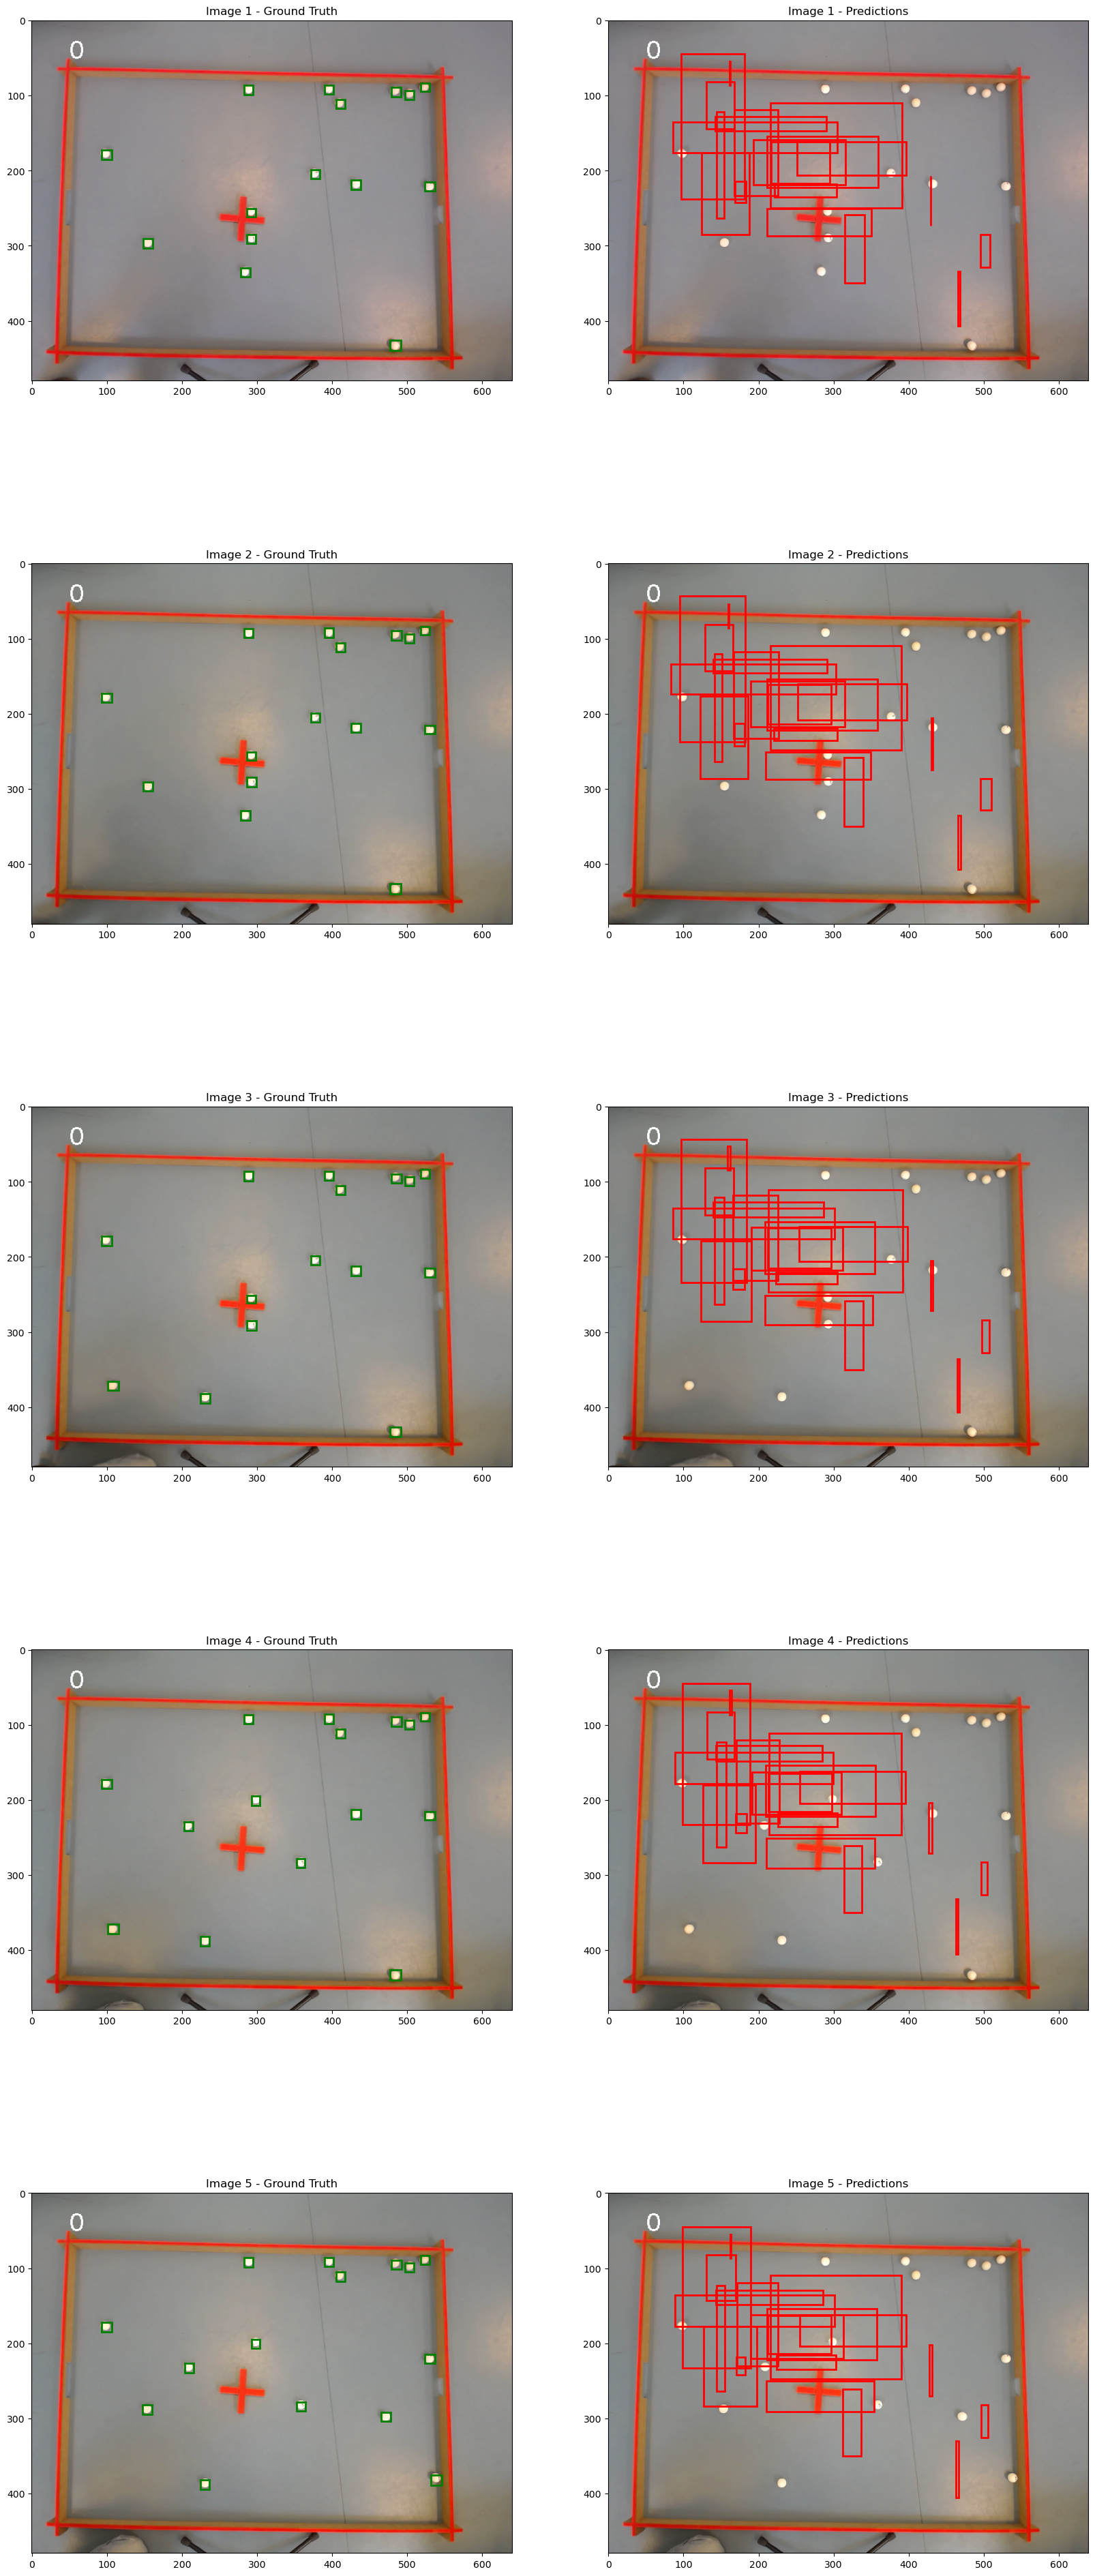

In [2]:
show_predictions(model, image_paths, json_paths)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.2851 - iou: 5.4986e-05 - loss: 0.5887 - mse: 0.5887
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.2634 - iou: nan - loss: 0.3588 - mse: 0.3588      
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1997 - iou: nan - loss: 0.2966 - mse: 0.2966 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1712 - iou: nan - loss: 0.3079 - mse: 0.3079
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.1544 - iou: nan - loss: 0.3146 - mse: 0.3146
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.1118 - iou: nan - loss: 0.3303 - mse: 0.3303      
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1033 - iou: nan - loss: 0.2674 - mse: 0.2674 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1344 - iou: nan - loss: 0.2817 - mse: 0.2817
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0995 - iou: nan - loss: 0.3029 - mse: 0.3029
Epoch 10/10
3/3 ━━━━━━

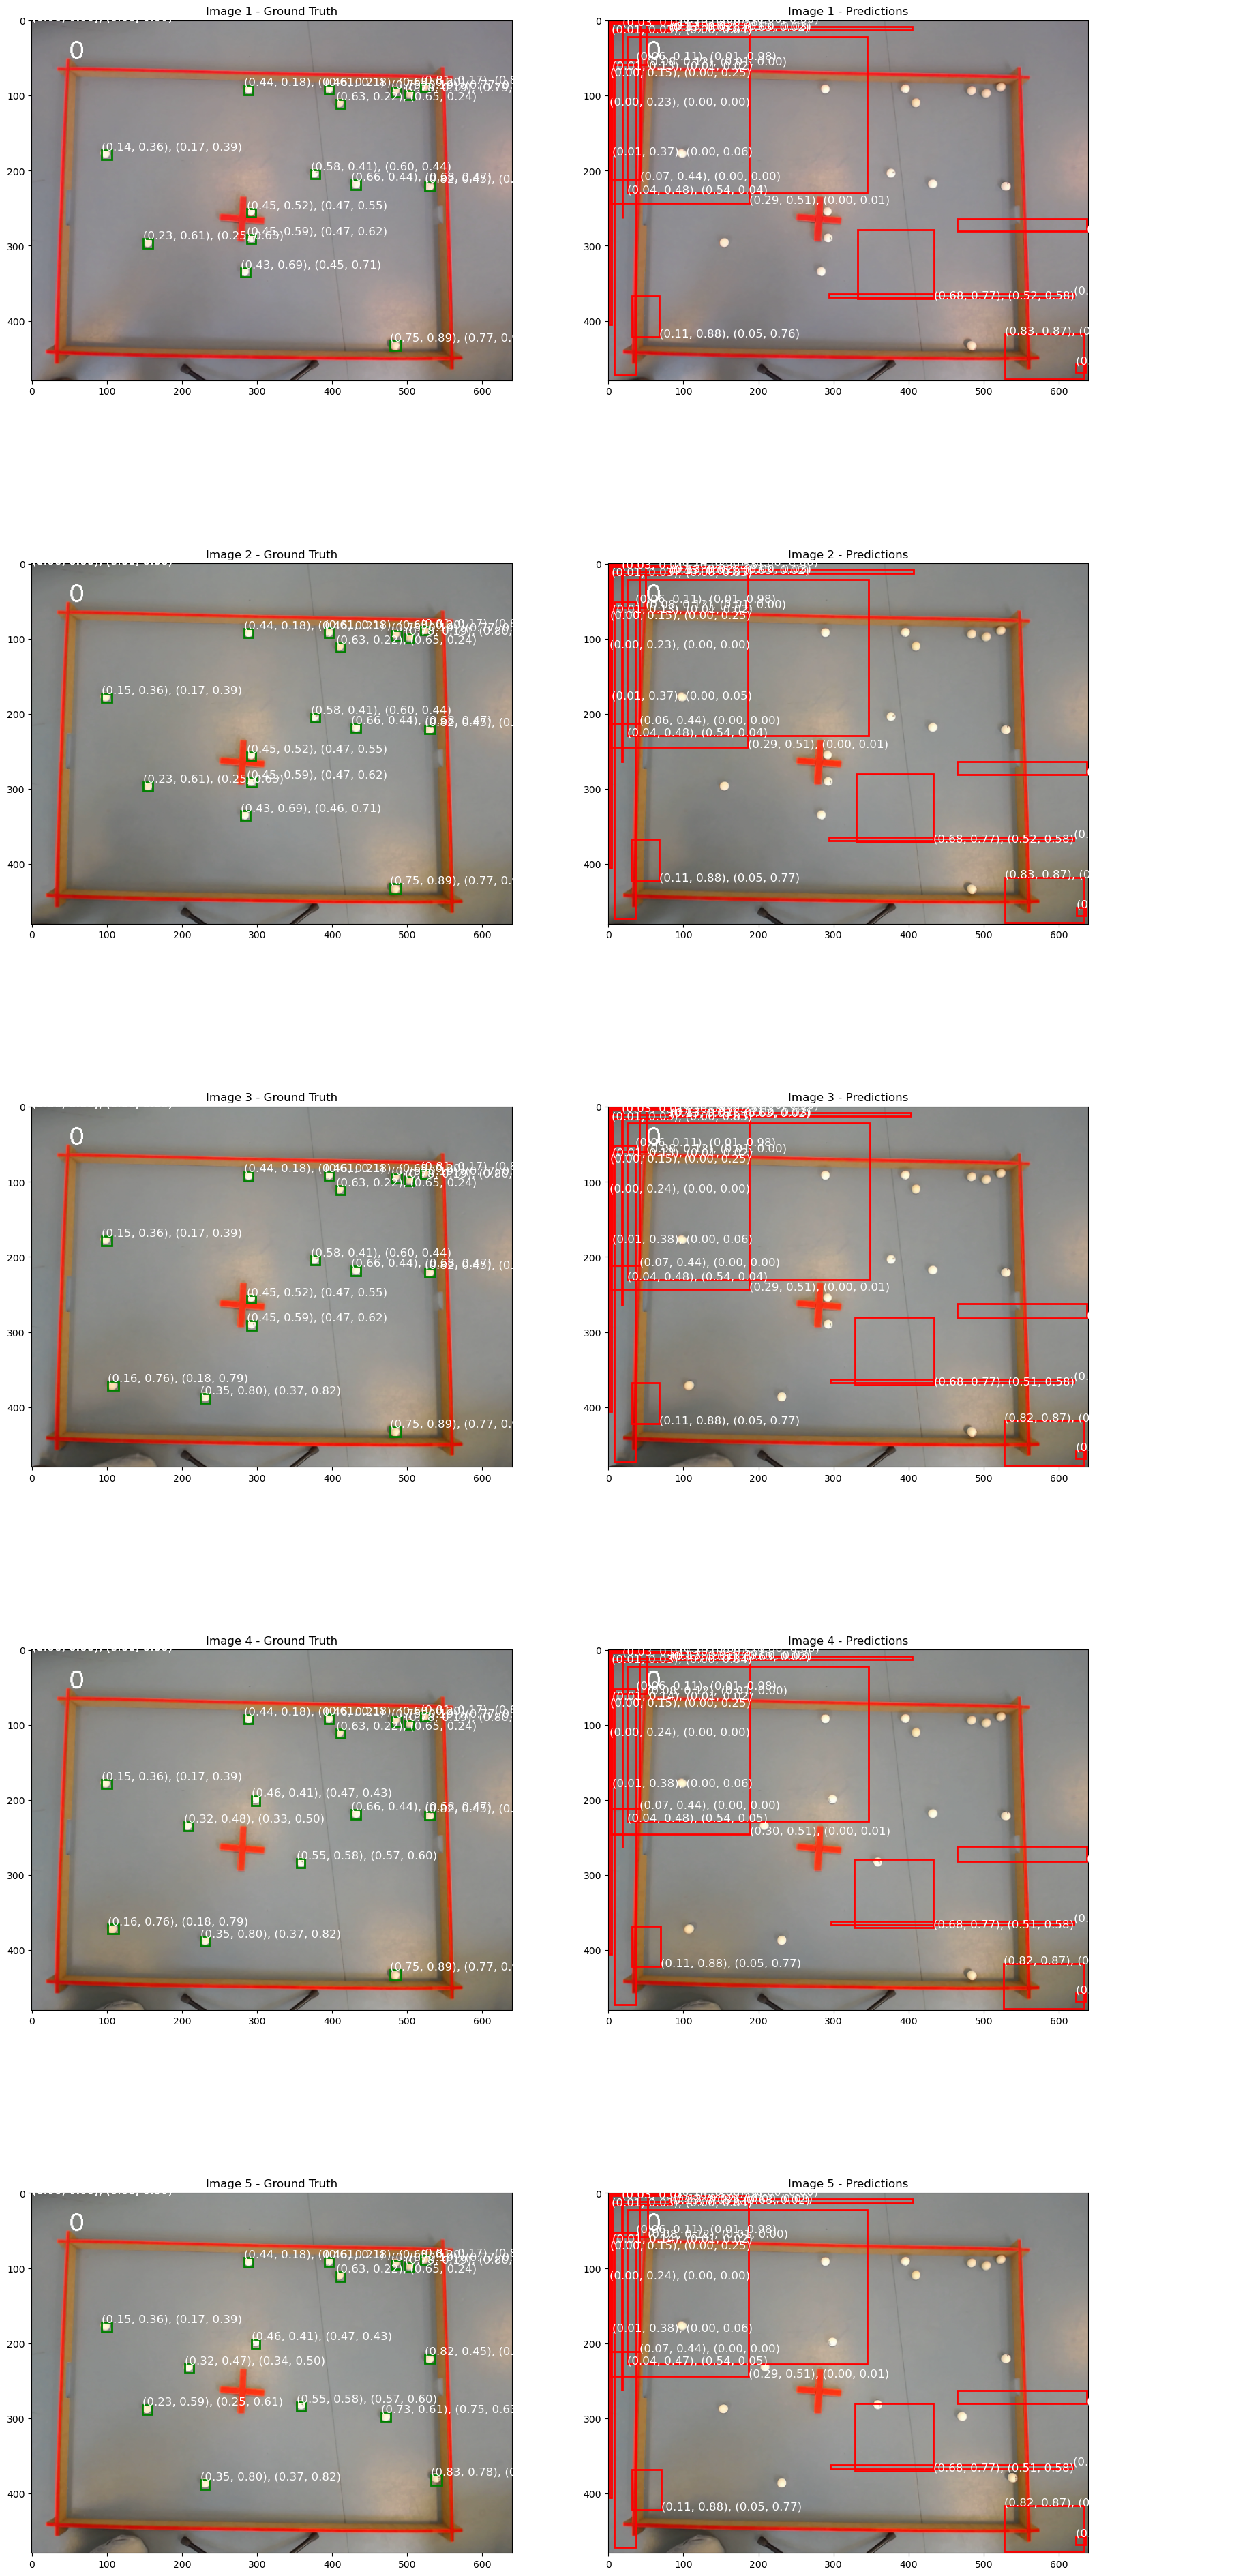

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np
import json
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define Image Data Generator for Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augmented_data_generator(image_paths, json_paths, batch_size, num_boxes=20):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                image = load_image(image_paths[i])
                labels = load_labels(json_paths[i], 256, 256, num_boxes)
                image = image.reshape((1,) + image.shape)
                image = next(data_gen.flow(image, batch_size=1))[0]
                batch_images.append(image)
                batch_labels.append(labels)
            yield np.array(batch_images), np.array(batch_labels)

def load_image(image_path, resize=True):
    with Image.open(image_path) as img:
        if resize:
            img = img.resize((256, 256))
        return np.array(img) / 255.0

def load_labels(json_path, img_width, img_height, num_boxes=20):
    labels = []
    with open(json_path, 'r') as file:
        data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center, y_center = float(box['x']), float(box['y'])
                width, height = float(box['width']), float(box['height'])
                x_min = (x_center - width / 2) / img_width
                y_min = (y_center - height / 2) / img_height
                x_max = (x_center + width / 2) / img_width
                y_max = (y_center + height / 2) / img_height
                labels.append([x_min, y_min, x_max, y_max])
    labels += [[0, 0, 0, 0]] * (num_boxes - len(labels))
    return labels

'''
def create_model(num_boxes=20, num_coords=4):
    model = Sequential([
        Input(shape=(256, 256, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model
    '''

def create_enhanced_model(num_boxes=12, num_coords=4):
    model = Sequential([
        Input(shape=(256, 256, 3)),
        Conv2D(64, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Conv2D(128, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Conv2D(256, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model


def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersect_mins = tf.maximum(y_true[..., :2], y_pred[..., :2])
    intersect_maxs = tf.minimum(y_true[..., 2:], y_pred[..., 2:])
    intersect_wh = tf.maximum(intersect_maxs - intersect_mins, 0.0)
    intersection = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_area = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    pred_area = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])
    union = true_area + pred_area - intersection
    iou = intersection / union
    return iou

def compile_model(model, learning_rate=0.0001):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse', 
                  metrics=['mse', 'accuracy', iou])

def train_model(model, train_gen, steps_per_epoch, epochs=10):
    return model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs)

def show_predictions(model, image_paths, json_paths, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples * 10))
    for i in range(num_samples):
        original_img = load_image(image_paths[i], resize=False)
        model_input_img = load_image(image_paths[i], resize=True)
        original_width, original_height = original_img.shape[1], original_img.shape[0]
        labels = load_labels(json_paths[i], original_width, original_height)
        predictions = model.predict(np.expand_dims(model_input_img, 0))[0]
        for ax, title, boxes in zip(axs[i], ['Ground Truth', 'Predictions'], [labels, predictions]):
            ax.imshow(original_img)
            ax.set_title(f'Image {i+1} - {title}')
            for box in boxes:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle(
                    (x_min * original_width, y_min * original_height),
                    (x_max - x_min) * original_width,
                    (y_max - y_min) * original_height,
                    linewidth=2, edgecolor='r' if title == 'Predictions' else 'g', facecolor='none')
                ax.add_patch(rect)
                label_text = f"({x_min:.2f}, {y_min:.2f}), ({x_max:.2f}, {y_max:.2f})"
                ax.text(x_min * original_width, y_min * original_height, label_text, color='white', fontsize=12)
    plt.show()

if __name__ == "__main__":
    image_paths = [f'../images/image_{i}.png' for i in range(1, 100)]
    json_paths = [f'../json_labeling/label_{i}.json' for i in range(1, 100)]
    model = create_model()
    compile_model(model)
    train_gen = augmented_data_generator(image_paths, json_paths, batch_size=32)
    history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // 32)
    show_predictions(model, image_paths, json_paths)

